In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split

# Load the MNIST dataset
(X, y), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalize the image data to [0, 1] range
X = X.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Resize the images to 32x32 and convert to 3 channels (RGB)
X_resized = np.array([tf.image.resize(tf.expand_dims(x, -1), (32, 32)) for x in X])  # Add channel dimension
X_resized = np.repeat(X_resized, 3, axis=-1)  # Repeat grayscale values to create 3 channels

X_test_resized = np.array([tf.image.resize(tf.expand_dims(x, -1), (32, 32)) for x in X_test])  # Add channel dimension
X_test_resized = np.repeat(X_test_resized, 3, axis=-1)  # Repeat grayscale values to create 3 channels

# Split the dataset into training, validation, and testing subsets
X_train, X_val, y_train, y_val = train_test_split(X_resized, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)

# Print the shapes to verify the data dimensions
print(X_train.shape, X_val.shape, X_test.shape)


(36000, 32, 32, 3) (12000, 32, 32, 3) (12000, 32, 32, 3)


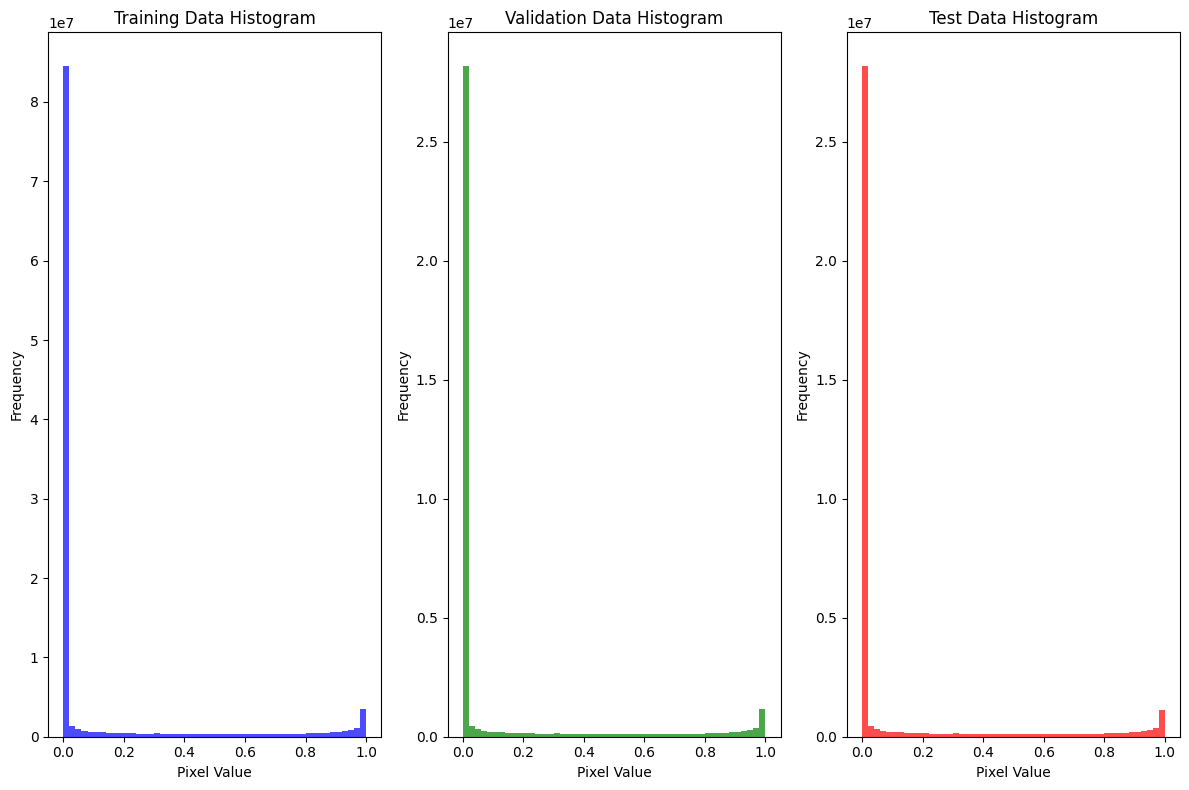

In [10]:
import matplotlib.pyplot as plt

# Plot histograms for the pixel values in the training, validation, and test datasets
plt.figure(figsize=(12, 8))

# Training dataset histogram
plt.subplot(1, 3, 1)
plt.hist(X_train.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Training Data Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Validation dataset histogram
plt.subplot(1, 3, 2)
plt.hist(X_val.flatten(), bins=50, color='green', alpha=0.7)
plt.title('Validation Data Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Test dataset histogram
plt.subplot(1, 3, 3)
plt.hist(X_test.flatten(), bins=50, color='red', alpha=0.7)
plt.title('Test Data Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()


In [33]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

# Load the VGG16 model pre-trained on ImageNet, without the top layers (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of VGG16
for layer in base_model.layers:
    layer.trainable = False  # Freeze only the base model layers

# Build the transfer learning model
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(32, 32, 3)))

# # Add the pre-trained VGG16 base model
model.add(base_model)

# # Add a global average pooling layer to reduce the feature maps to a single vector
model.add(layers.GlobalAveragePooling2D())

# # Add dense layers (fully connected layers)
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

# # Add the output layer with 10 classes (for MNIST)
model.add(layers.Dense(10, activation='softmax'))

# # Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Display the model summary
model.summary()

# from tensorflow.keras import layers, models

# # Build the model
# model = models.Sequential()

# # Specify the input shape for the first dense layer
# model.add(layers.InputLayer(input_shape=(32, 32, 3)))  # Input shape for the image data

# # Add the dense layers (fully connected layers)
# model.add(layers.Flatten())  # Flatten the input before passing it to dense layers
# model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(32, activation='relu'))

# # Add the output layer with 10 classes (for MNIST)
# model.add(layers.Dense(10, activation='softmax'))

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Display the model summary
# model.summary()



Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,791,018 (56.42 MB)

 Trainable params: 76,330 (298.16 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [34]:
# Train the model for 20 epochs
history = model.fit(
    X_train, y_train, 
    epochs=5, 
    batch_size=64, 
    validation_data=(X_val, y_val)
)

# Optionally: Evaluate the model on the test set after training
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc}')

Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.7167 - loss: 0.9309 - val_accuracy: 0.9361 - val_loss: 0.2057
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9385 - loss: 0.1989 - val_accuracy: 0.9490 - val_loss: 0.1557
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9522 - loss: 0.1535 - val_accuracy: 0.9435 - val_loss: 0.1684
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9576 - loss: 0.1313 - val_accuracy: 0.9616 - val_loss: 0.1183
Epoch 5/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.9603 - loss: 0.1229 - val_accuracy: 0.9607 - val_loss: 0.1201
375/375 - 2s - 6ms/step - accuracy: 0.9611 - loss: 0.1215
Test accuracy: 0.9610833525657654


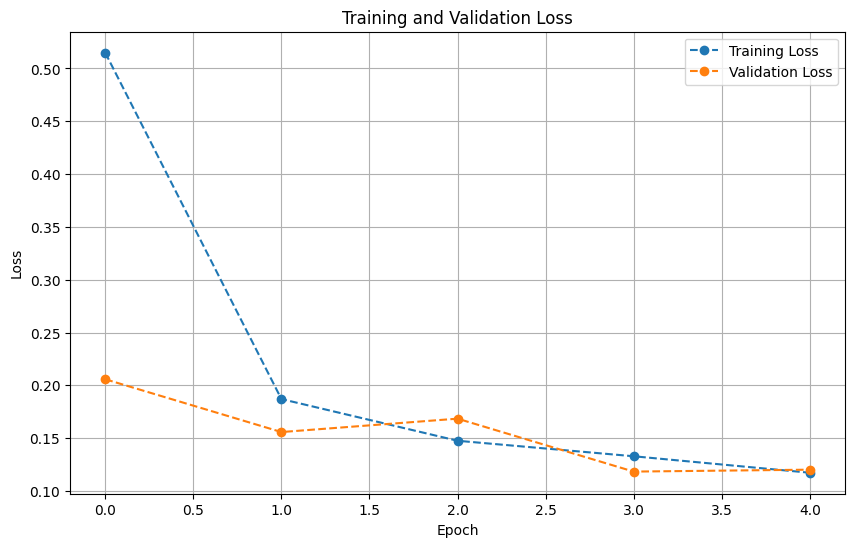

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()